In [2]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 8


# 1. Import required modules

In [3]:
import matplotlib
import numpy as np # arrays, fourier transformatie, matrixen, domein lineaire algabra
import pandas as pd # analyseren van data 
import seaborn as sns
from sklearn import metrics
import statsmodels.api as sm
import sklearn as sl
#
from ModelFitCV import ModelTrainCV, PrintTrainCVScores, PrintListScoresTrainCV
from statistics import mean, stdev
from numpy import mean
from numpy import std
from sklearn import preprocessing
# splitsen dataset:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
# ML algorithme
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# scores
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
# plotten
import matplotlib.pyplot as plt
%matplotlib inline
# feature selectie
from sklearn.feature_selection import RFECV

print('All libraries are installed')

All libraries are installed


# 2. Read data

In [4]:
dataset = pd.read_csv('dfFeaturesTGO_train.csv')

# 3. Formulate X and Y:

In [5]:
X_features = dataset.drop(columns=['label'])
Y_label=dataset['label']


# 4. Scaling of the data <br>
Standardization is the process of transforming data in a way such that the mean of each column becomes equal to zero, and the standard deviation of each column is one. This way, you obtain the same scale for all columns. Take the following steps to standardize your data: <br>
Calculate the mean and standard deviation for each column. <br>
Subtract the corresponding mean from each element. <br>
Divide the obtained difference by the corresponding standard deviation. <br>

By scaling the data of our dataset the measurements of the different features are directly comparable.

In [6]:
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(X_features)

# 5. Splitting the data <br>
First we create a training and a testing dataset. The training set will be used for training and validation of the model. With validation we mean that we evaluate the different settings of the hyperparameters on the estimations performed by the model. Afterwhich, we will perform a final evaluation of the model on the test set. <br>
By setting the random state to an integer the split is reproducible for repeated use of the function. <br>
By setting the stratify argument to Y_label component of the original dataset the train and the test set will have the same distribution of epileptic and non-epileptic observations as the original dataset. <br>

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, Y_label, test_size=0.2, random_state=0, stratify=Y_label)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(38099, 66) (38099,)
(9525, 66) (9525,)


# 6. Creating the classifier model

In [8]:
lr_model = LogisticRegression(max_iter=10000)

# 7. Stratified Cross Validation & Fitting of model after scaling<br>
Using stratisfied K-fold CrossValidation. This means that we will create k-folds of testing and training sets wihtin the previously created training set. This ensures that we do not have to use our testingdata for validating the model after evaluating the effect feature selection and tuning of the hyperparameters from the model.<br>

With stratification we will keep the distribution of the epileptic (Label =1) and non-epileptic patients over the training and validation set. <br>

By using the function .fit which describes the process of calculating the best weights using the available observations. The function calculates the best weights by maximizing the log-likelihood function(LLF) for all observations i.<br>
We will first use this function for the model with default settings and using all available features to get a baseline for the performance of the model.


In [9]:
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

f1_baseline_fold_sc, accuracy_baseline_fold_sc, spec_baseline_fold_sc, sens_baseline_fold_sc, lr_model = ModelTrainCV(lr_model, skf, x_train, y_train)

### **F1-score and specificity after scaling:** <br>
Baseline scores for performance of the model. Optimalizations are yet to be performed.

In [10]:
PrintTrainCVScores(f1_baseline_fold_sc, accuracy_baseline_fold_sc, spec_baseline_fold_sc, sens_baseline_fold_sc)

List of possible f1: [0.8078322647721364, 0.7975757575757575, 0.8042951160374091, 0.8036998972250771, 0.8071278825995807, 0.8092685457375064, 0.8055797733217088, 0.7956204379562043, 0.8147375738616616, 0.8055315471045807]

Maximal f1: 0.815

Minimal f1: 0.796

Average f1: 0.805

Standard deviation (f1): 0.005491
-------

List of possible specificity: [0.9130434782608695, 0.9020759890325107, 0.9095182138660399, 0.918918918918919, 0.9048178613396005, 0.9165687426556992, 0.9048178613396005, 0.8965922444183314, 0.918135526831179, 0.9130094043887147]

Maximal specificity: 91.9 %

Minimal specificity: 89.7 %

Average specificity: 91.0 %

Standard deviation (specificity): 0.007476
-------

List of possible accuracy: [0.7089238845144357, 0.6931758530183727, 0.7034120734908137, 0.6992125984251969, 0.710236220472441, 0.710498687664042, 0.7073490813648294, 0.6913385826771653, 0.7202099737532809, 0.7046468889472303]

Maximal accuracy: 72.0 %

Minimal accuracy: 69.1 %

Average accuracy: 70.5 %

Sta

### **Coefficients:** <br>
Evaluating the coefficients given to each feature after training the model.<br> The coefficient value is a measure for the dependency of the outcome on the coresponding feature given that all other features remain constant (=conditional dependency); with a change of 1 unit of a feature the outcome will change with the coresponding coefficient. <br>
This means that a large coefficient value for a specific feature means that this feature had a big impact on the outcome we're trying to predict.


In [11]:
lr_model.intercept_

lr_model.coef_

coefficents=lr_model.coef_
coefficents.shape
coefficents=np.reshape(coefficents, 66)

pd.DataFrame(coefficents, X_features.columns, columns=['coefficients']).sort_values(by='coefficients', ascending=False) 

,coefficients
Spectral kurtosis,1.383768
Sum absolute diff,1.346263
Mean absolute diff,1.346263
abs delta,1.067981
abs alpha,1.058452
...,...
Min,-1.327821
abs fast ripple,-1.413401
Root mean square,-1.558739
Standard deviation,-1.563459


Multiplying coefficients bij the standard deviation of the related feature will reduce all coefficients to the same unit of measure which makes them directly comparable.<br>
The figure below shows the coefficients given to the features from the dataset by the LogisticRegression model. <br>


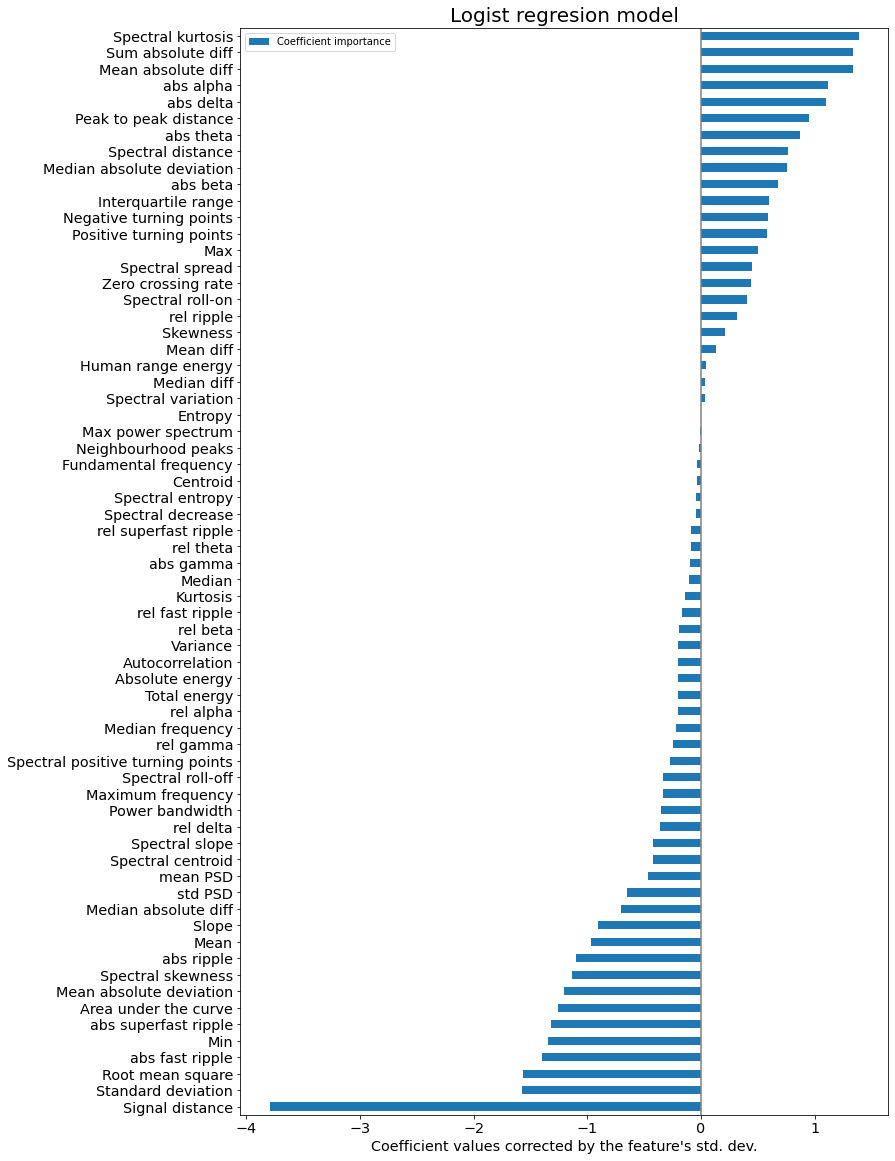

In [12]:
feature_names = X_features.columns
coefficents=lr_model.coef_
coefficents.shape
coefficents=np.reshape(coefficents, 66)

coefs = pd.DataFrame(
   coefficents * x_train.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
).sort_values(by='Coefficient importance', ascending=True) 

coefs.plot(kind="barh", figsize=((15, 20)), fontsize = 'x-large')
plt.xlabel("Coefficient values corrected by the feature's std. dev.", fontsize = 'x-large' )
plt.title("Logist regresion model", fontsize = 20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

# 8. Feature Selection <br>


**Recursive Feature Elimination (RFE)** <br>
This method of feature selection will select features by repeatedly evaluating the model and with each repeat the worst performing feature will be removed. This process will be repeated untill the desired number of features is selected. <br>
The importance of each feature as giving by its coefficient, this is the measure used for determening the performance of the feature.

RFECV is a method that performs RFE in a cross-validation loop to find the optimal number of features. This is the method that will be used for our model.



In [13]:
#estimator = RandomForestClassifier(n_estimators=100, max_depth=10)
#feature_selector = RFECV(estimator, step=1, cv=skf, n_jobs=n_cpu-2)
#feature_selector = feature_selector.fit(x_train, y_train)
#print("Optimal number of features : %d" %feature_selector.n_features_)
#feature_selector.ranking_

### **Creating a new x variable with the selected features:**

In [14]:
#x_selected_features = feature_selector.get_support(1)
#x_selected_features = x_train[:, x_selected_features]

#lijst = X_features.columns[feature_selector.support_] 
#print(lijst)

x_selected_features = x_train[:, [ 2,  3,  4,  5,  6,  8,  9, 10, 12, 13, 14, 32, 36, 37, 38, 40, 41,
       43, 45, 46, 51, 53, 57, 59, 62]]

x_test_selected_features = x_test[:, [ 2,  3,  4,  5,  6,  8,  9, 10, 12, 13, 14, 32, 36, 37, 38, 40, 41,
       43, 45, 46, 51, 53, 57, 59, 62]]

In [15]:
#feature_selector.get_support(1)

### **training the model with the selected features and evaluating the new peformance:**


In [16]:
f1_rfe_fold_sc, accuracy_rfe_fold_sc, spec_rfe_fold_sc, sens_rfe_fold_sc, lr_model = ModelTrainCV(lr_model, skf, x_selected_features,y_train)

PrintTrainCVScores(f1_rfe_fold_sc, accuracy_rfe_fold_sc, spec_rfe_fold_sc, sens_rfe_fold_sc)

List of possible f1: [0.8081674673987645, 0.8026089941640919, 0.8028747433264887, 0.807600950118765, 0.8051008099259003, 0.81160409556314, 0.8039081247857388, 0.8043143297380585, 0.8141321044546851, 0.8067657611481291]

Maximal f1: 0.814

Minimal f1: 0.803

Average f1: 0.807

Standard deviation (f1): 0.003796
-------

List of possible specificity: [0.9224441833137486, 0.9157853505679593, 0.918918918918919, 0.9322365844104975, 0.9150019584802194, 0.9314531923227576, 0.918527222875049, 0.9200940070505288, 0.9341950646298472, 0.9251567398119123]

Maximal specificity: 93.4 %

Minimal specificity: 91.5 %

Average specificity: 92.3 %

Standard deviation (specificity): 0.007045
-------

List of possible accuracy: [0.7065616797900263, 0.6981627296587927, 0.6976377952755906, 0.7023622047244095, 0.7031496062992126, 0.710236220472441, 0.6997375328083989, 0.7, 0.7141732283464567, 0.7030716723549488]

Maximal accuracy: 71.4 %

Minimal accuracy: 69.8 %

Average accuracy: 70.4 %

Standard deviation (

# 10. Tuning hyperparameters <br>
### **Create search space** <br>
For logistic Regression models the following parameters were evaluated using GridSearch.
- solver ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:<br>
    Algorithm which is used to solve the cost function
- penalty ['none', 'l1', 'l2', 'elasticnet']: <br>
    penalty term which is added to the cost funtion
- C [100, 10, 1.0, 0.1, 0,01]: <br>
    regularization parameter. For small values of C the regularization strength is higher. This means the model will be simple and is likely to underfit. For larg values of C, the regularization strengt is lower which leads to a more complex model. This can lead to overfitting.


In [17]:
param_grid = [
    { 'solver' : ['newton-cg', 'lbfgs', 'sag'], 'penalty' : ['l2', 'none'], 'C' : [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]},
    { 'solver' : ['liblinear'], 'penalty' : ['l1', 'l2'], 'C' : [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]},
    { 'solver' : ['saga'], 'penalty' : ['elasticnet', 'l1', 'l2', 'none'], 'C' : [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]}
]

### **Run the GridSearch**

In [18]:
#Setting refit='AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score.
#Grid_Search = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=param_grid, cv=skf, verbose=0, n_jobs=6)
#Grid_Search.fit(x_selected_features, y_train)
#Grid_Search.best_params_


### **Printing the results of the GridSearch per fold**

In [19]:
#lr_model=LogisticRegression(solver=Grid_Search.best_estimator_.solver, penalty=Grid_Search.best_estimator_.penalty, C=Grid_Search.best_estimator_.C)
#lr_model = Grid_Search.best_estimator_
lr_model = LogisticRegression(C=1.0, penalty = 'l2', solver= 'saga', max_iter=10000)

In [20]:
f1_GS_fold_sc, accuracy_GS_fold_sc, spec_GS_fold_sc, sens_GS_fold_sc, lr_model = ModelTrainCV(lr_model, skf, x_selected_features,y_train)
PrintTrainCVScores(f1_GS_fold_sc, accuracy_GS_fold_sc, spec_GS_fold_sc, sens_GS_fold_sc)


### **Updated coefficients from LogisticRegression model:**

In [ ]:
lr_model.intercept_
feature_selector_suport = ([False, False,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True,  True, False, False, False, False,  True, False,  True,
       False, False, False,  True, False,  True, False, False,  True,
       False, False, False])

coefficents=lr_model.coef_
coefficents.shape
coefficents=np.reshape(coefficents, 25)

pd.DataFrame(coefficents, X_features.columns[feature_selector_suport], columns=['coefficients']).sort_values(by='coefficients', ascending=False) 

,coefficients
Mean absolute diff,1.464805
Sum absolute diff,1.464805
abs alpha,0.826955
abs beta,0.607850
Negative turning points,0.559821
Positive turning points,0.556034
Spectral distance,0.551505
Spectral kurtosis,0.504493
rel fast ripple,0.131290
Spectral skewness,0.055698


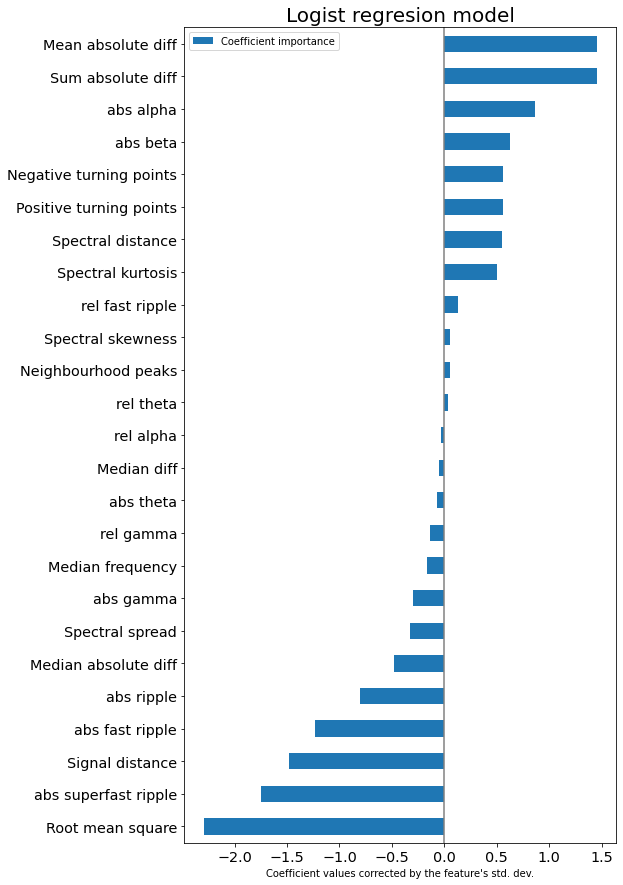

In [ ]:
feature_names = X_features.columns[feature_selector_suport]

coefs = pd.DataFrame(
   coefficents * x_selected_features.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
).sort_values(by='Coefficient importance', ascending=True) 

coefs.plot(kind="barh", figsize=((10, 15)), fontsize='x-large')
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Logist regresion model", fontsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

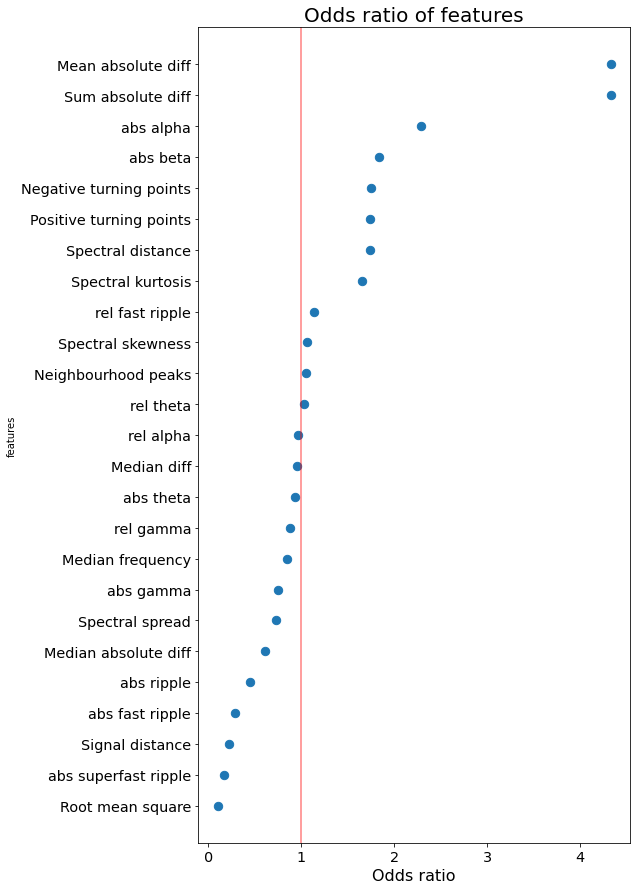

In [ ]:
odds_ratio_coeff = np.exp(coefficents)

coefs_OR = pd.DataFrame(
   odds_ratio_coeff ,
    columns=["odds_ratio"],
    index=feature_names,
).sort_values(by='odds_ratio', ascending=True) 

coefs_OR.reset_index(inplace=True)
coefs_OR = coefs_OR.rename(columns = {'index':'features'})

coefs_OR.plot(kind="scatter",marker="o", s=70, x='odds_ratio', y='features', figsize=((10, 15)), fontsize='x-large')
plt.xlabel("Odds ratio", fontsize=16)
plt.title("Odds ratio of features", fontsize=20)
plt.axvline(x=1, color="red", alpha=.5)
plt.subplots_adjust(left=0.3)

# 11. Evaluation Logistic Regression Model


In [ ]:
y_pred = lr_model.predict(x_test_selected_features)

#### **Evaluation scores & Confusion matrix:** <br>

Positive likelihood ratio 3.1024448182453126 
Negative likelihood ratio 0.8205055614355192

 precision 0.6044129235618597 
 sensitiviteit 0.24403436207445117 
 specificitity 0.9213412723284237 
 accuracy 0.6978477690288714 
 f1 score 0.3476881233000907


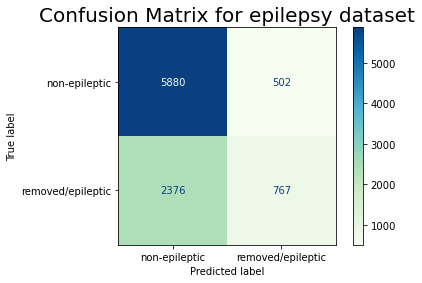

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-epileptic', 'removed/epileptic'])
disp.plot(cmap = 'GnBu')
disp.ax_.set_title("Confusion Matrix for epilepsy dataset", fontsize=20)

spec = cm[0,0]/(cm[0,0]+cm[0,1]) #TN/(TN+FP)
recall = recall_score(y_test, y_pred) #sensitivity; TP/(TP+FN)
LR_pos = recall / (1-spec) #>1.0
LR_neg = (1-recall) / spec #<1.0
print('Positive likelihood ratio', LR_pos,'\nNegative likelihood ratio', LR_neg)

precision = precision_score(y_test, y_pred) #TP/(TP+FP)
recall_sens = recall_score(y_test,y_pred,pos_label=1) #sensitivity; TP/(TP+FN)
recall_spec = recall_score(y_test,y_pred,pos_label=0) #TN/(TN+FP)
accuracy_1 = accuracy_score(y_test,y_pred) #(TN+TP)/(TN+FP+FN+TP)
f1score = f1_score(y_test,y_pred) #F1 = 2 * (precision * recall) / (precision + recall)
print('\n precision', precision, '\n sensitiviteit', recall_sens,'\n specificitity', recall_spec, '\n accuracy', accuracy_1, '\n f1 score', f1score)

### **Classification report:**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.92      0.80      6382
           1       0.60      0.24      0.35      3143

    accuracy                           0.70      9525
   macro avg       0.66      0.58      0.58      9525
weighted avg       0.68      0.70      0.65      9525



### **ROC curve:**
This curve sumerizes the classification performance of the model for the positive classifications <br>
**AUC** is the area under the curve <br>
The x-as describes the false positive rate and the y-as describes the true positve rate

c:\Users\margo\anaconda3\envs\baseupdated\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


TypeError: xlabel() missing 1 required positional argument: 'xlabel'

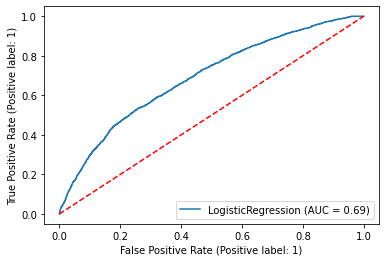

In [ ]:
plot_roc_curve(lr_model, x_test_selected_features, y_test)
plt.plot([0, 1], [0, 1],'r--', label='No Skill') 
plt.xlabel()
plt.ylabel() 


### **Precision-Recall curve:**

c:\Users\margo\anaconda3\envs\baseupdated\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


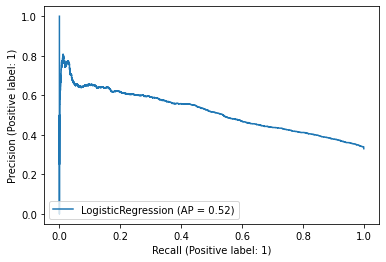

In [ ]:
plot_precision_recall_curve(lr_model, x_test_selected_features, y_test)
plt.show(fontsize=20)

# Changing the threshold value for classification: <br>
We will test different threshold values: the only certainty of our dataset is that the negative observations are actually negative and that the EZ was removed. It is possible that some of the observations that were labeled positive may be measurements from healty brain tissue that was removed either as a precaussion margin, to get to the epileptic tissue of falsly classified as epileptic. <br>
This is why we will focus on the threshold values that will minimizes the false positve rate or the specificity.

In [ ]:
acc_threshold = []
spec_threshold = []
f1_threshold = []
sens_threshold = []

pred_proba_df = pd.DataFrame(lr_model.predict_proba(x_test_selected_features))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score((y_test),
                        Y_test_pred.iloc[:,[1]])
    
    print('Our testing accuracy is {:.1%}'.format((test_accuracy)))
   
    f1 = f1_score(y_test, Y_test_pred.iloc[:,[1]])
    print('f1-score is {:.3f}'.format(f1))

    specificity = recall_score(y_test, Y_test_pred.iloc[:,[1]], pos_label=0)
    sensitivity = recall_score(y_test, Y_test_pred.iloc[:,[1]],pos_label=1)
    print("specificity is {:.1f}%".format((specificity)*100))
    print("sensitivity is {:.1f}%".format((sensitivity)*100))

    acc_threshold.append('{:.1f}'.format((test_accuracy)*100))
    spec_threshold.append('{:.1f}'.format((specificity)*100))
    f1_threshold.append('{:.3f}'.format(f1))
    sens_threshold.append('{:.1f}'.format((sensitivity)*100))
    
    
    print(confusion_matrix(y_test, Y_test_pred.iloc[:,[1]]))
 


******** For i = 0.05 ******
Our testing accuracy is 35.8%
f1-score is 0.506
specificity is 4.4%
sensitivity is 99.7%
[[ 278 6104]
 [   8 3135]]

******** For i = 0.1 ******
Our testing accuracy is 36.6%
f1-score is 0.508
specificity is 5.8%
sensitivity is 99.2%
[[ 368 6014]
 [  25 3118]]

******** For i = 0.15 ******
Our testing accuracy is 39.0%
f1-score is 0.514
specificity is 10.0%
sensitivity is 97.9%
[[ 641 5741]
 [  67 3076]]

******** For i = 0.2 ******
Our testing accuracy is 45.1%
f1-score is 0.527
specificity is 21.6%
sensitivity is 92.8%
[[1376 5006]
 [ 227 2916]]

******** For i = 0.25 ******
Our testing accuracy is 53.4%
f1-score is 0.542
specificity is 38.5%
sensitivity is 83.6%
[[2458 3924]
 [ 515 2628]]

******** For i = 0.3 ******
Our testing accuracy is 60.2%
f1-score is 0.541
specificity is 54.8%
sensitivity is 71.1%
[[3500 2882]
 [ 909 2234]]

******** For i = 0.35 ******
Our testing accuracy is 65.0%
f1-score is 0.526
specificity is 68.1%
sensitivity is 58.8%
[[4

In [ ]:
print(f1_threshold)
print(spec_threshold)
print(acc_threshold)
print(sens_threshold)

['0.506', '0.508', '0.514', '0.527', '0.542', '0.541', '0.526', '0.503', '0.439', '0.348', '0.255', '0.153', '0.085', '0.050', '0.021', '0.009', '0.006', '0.003', '0.001', '0.000']
['4.4', '5.8', '10.0', '21.6', '38.5', '54.8', '68.1', '78.8', '86.5', '92.1', '95.6', '97.7', '98.9', '99.6', '99.9', '99.9', '99.9', '99.9', '100.0', '100.0']
['35.8', '36.6', '39.0', '45.1', '53.4', '60.2', '65.0', '68.7', '69.8', '69.8', '69.3', '68.3', '67.7', '67.6', '67.3', '67.1', '67.0', '67.0', '67.0', '67.0']
['99.7', '99.2', '97.9', '92.8', '83.6', '71.1', '58.8', '48.1', '35.9', '24.4', '15.9', '8.7', '4.5', '2.6', '1.0', '0.5', '0.3', '0.1', '0.1', '0.0']


In [ ]:
f1_threshold = [0.506, 0.508, 0.514, 0.527, 0.542, 0.541, 0.526, 0.503, 0.439, 0.348, 0.255, 0.153, 0.085, 0.050, 0.021, 0.009, 0.006, 0.003, 0.001, 0.000]
spec_threshold = [4.4, 5.8, 10.0, 21.6, 38.5, 54.8, 68.1, 78.8, 86.5, 92.1, 95.6, 97.7, 98.9, 99.6, 99.9, 99.9, 99.9, 99.9, 100.0, 100.0]
acc_threshold = [35.8, 36.6, 39.0, 45.1, 53.4, 60.2, 65.0, 68.7, 69.8, 69.8, 69.3, 68.3, 67.7, 67.6, 67.3, 67.1, 67.0, 67.0, 67.0, 67.0]
sens_threshold = [99.7, 99.2, 97.9, 92.8, 83.6, 71.1, 58.8, 48.1, 35.9, 24.4, 15.9, 8.7, 4.5, 2.6, 1.0, 0.5, 0.3, 0.1, 0.1, 0.0]

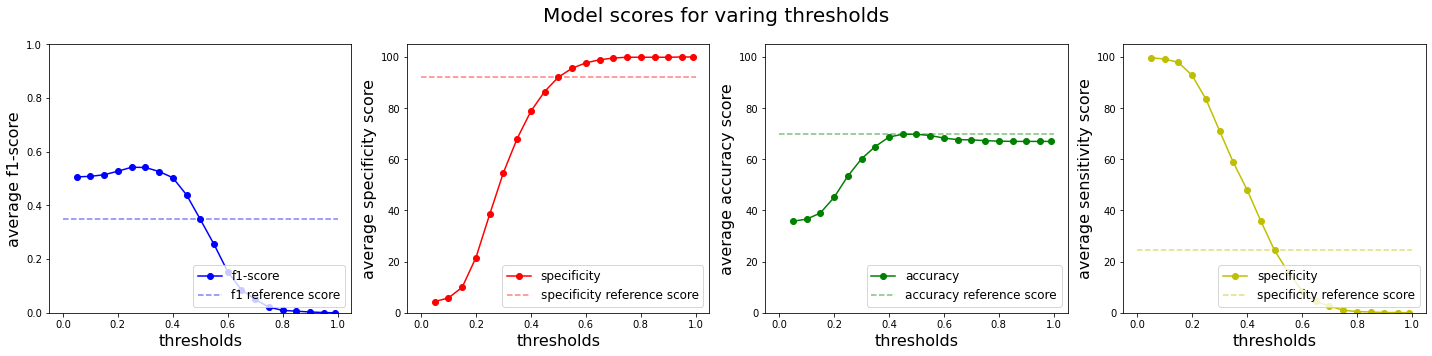

In [ ]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(20,5))
fig.suptitle('Model scores for varing thresholds', fontsize=20)


ax.set_ylim(0,1)
#ax.invert_yaxis()
ax.plot(threshold_list, f1_threshold, 'b-o', label='f1-score')
ax.hlines(y=((f1score)), xmin=0, xmax=1, linestyles='--', color='b', alpha=.5, label='f1 reference score')
ax.set_xlabel('thresholds', fontsize=16)
ax.set_ylabel('average f1-score', fontsize=16)
ax.legend(loc='lower right', fontsize=12)   

ax1.set_ylim(0,105)
ax1.plot(threshold_list, spec_threshold, 'r-o', label='specificity')
ax1.hlines(y=(((recall_spec)*100)), xmin=0, xmax=1, linestyles='--', color='r', alpha=.5, label='specificity reference score')
ax1.set_xlabel('thresholds', fontsize=16)
ax1.set_ylabel('average specificity score', fontsize=16)
ax1.legend(loc='lower right', fontsize=12)   

ax2.set_ylim(0,105)
ax2.plot(threshold_list, acc_threshold, 'g-o', label='accuracy')
ax2.hlines(y=(((accuracy_1)*100)), xmin=0, xmax=1, linestyles='--', color='g', alpha=.5, label='accuracy reference score')
ax2.set_xlabel('thresholds', fontsize=16)
ax2.set_ylabel('average accuracy score', fontsize=16)
ax2.legend(loc='lower right', fontsize=12)  

ax3.set_ylim(0,105)
ax3.plot(threshold_list, sens_threshold, 'y-o', label='specificity')
ax3.hlines(y=(((recall_sens)*100)), xmin=0, xmax=1, linestyles='--', color='y', alpha=.5, label='specificity reference score')
ax3.set_xlabel('thresholds', fontsize=16)
ax3.set_ylabel('average sensitivity score', fontsize=16)
ax3.legend(loc='lower right', fontsize=12)  

fig.tight_layout()

# Randomly changing epileptic labels

Randomly chaning a range of 5-50 percentage of the labelled 1 observations in the train set. Afterwhich, the model will be trained on the altered train set and re-evaluated on the unaltered test set.  

In [ ]:
repeats = [1, 2, 3, 4, 5]
percentage = [(.05, .95), (.1, .90), (.15, .85), (.2, .8), (.25, .75), (.3, .7), (.35, .65), (.4, .6), (.45, .55), (.5, 0.5)]

f1 = []
spec = []
sens =[]
acc = []

for p in percentage:
    print(p)

    for r in range(1,6):
        #y_series = pd.Series(y_train)
        df_y_train = y_train.to_frame()
        print((df_y_train.label==1).sum()) 
        epileptic_obs = df_y_train.label == 1
        df_y_train.loc[epileptic_obs, 'label'] = np.random.choice((0,1), epileptic_obs.sum(), p=(p))
        print((df_y_train.label==1).sum())

        f1_fold_sc, accuracy_fold_sc, spec_fold_sc, sens_fold_sc, lr2_model = ModelTrainCV(lr_model, skf, x_selected_features, df_y_train)
       
        pred_Y = lr2_model.predict(x_test_selected_features)

        recall_sens = recall_score(y_test,pred_Y,pos_label=1) #sensitivity; TP/(TP+FN)
        recall_spec = recall_score(y_test,pred_Y,pos_label=0) #TN/(TN+FP)
        accuracy = accuracy_score(y_test,pred_Y) #(TN+TP)/(TN+FP+FN+TP)
        f1score2 = f1_score(y_test,pred_Y) #F1 = 2 * (precision * recall) / (precision + recall)

        sens.append('{0:.1f}%'. format((recall_sens)*100))
        spec.append('{0:.1f}%'. format((recall_spec)*100))
        acc.append('{0:.1f}%'.format((accuracy)*100))
        f1.append('{0:.3f}'. format(f1score2))



(0.05, 0.95)
12570
11920


c:\Users\margo\anaconda3\envs\baseupdated\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\margo\anaconda3\envs\baseupdated\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\margo\anaconda3\envs\baseupdated\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\margo\anaconda3\envs\baseupdated\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when 

KeyboardInterrupt: 

Calculated mean test scores of the 5 repeats per percentage randomly changed labels: Calculations were performed with excell because the append list function did not work like expected/wanted.

In [ ]:
f1_perc = [.296, .244, .179, .115, .089, .053, .0322, .016, .010, .005]
acc_perc = [69.5, 69.2, 68.6, 68.0, 67.8, 67.6, 67.4, 67.2, 67.1, 67.1]
spec_perc = [94.2, 95.8, 97.2, 98.3, 98.9, 99.6, 99.8, 99.9, 99.9, 100]
sens_perc = [19.4, 15.1, 10.4, 6.3, 4.8, 2.7, 1.64, .82, .5, .26 ]
perc = [5, 10, 15,20,25,30,35,40,45,50]

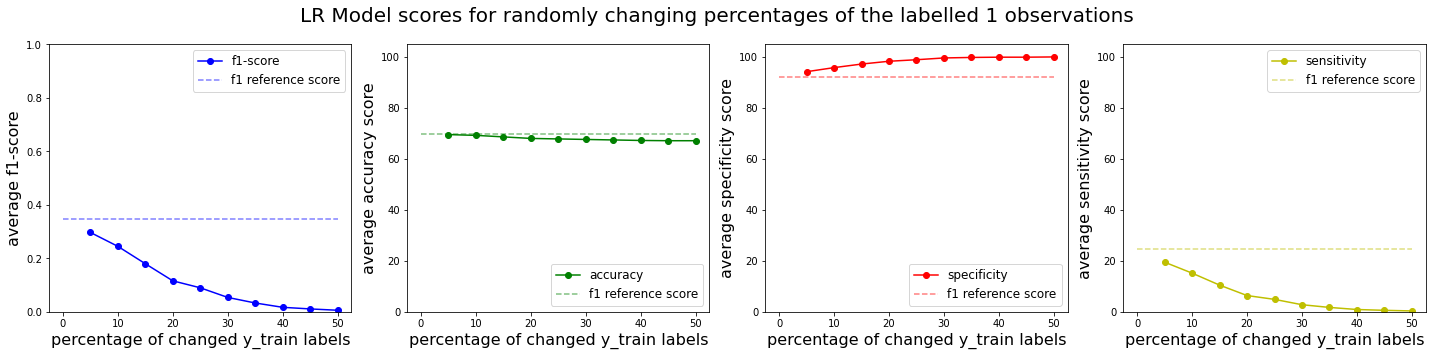

In [ ]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(20,5))
fig.suptitle('LR Model scores for randomly changing percentages of the labelled 1 observations', fontsize=20)

ax.set_ylim(0,1)
ax.plot(perc, f1_perc, 'b-o', label='f1-score')
ax.hlines(y=f1score, xmin=0, xmax=50, linestyles='--', color='b', alpha=.5, label='f1 reference score')
ax.set_xlabel('percentage of changed y_train labels', fontsize=16)
ax.set_ylabel('average f1-score', fontsize=16)
ax.legend(loc='upper right', fontsize=12)   

ax1.set_ylim(0, 105)
ax1.plot(perc, acc_perc, 'g-o', label='accuracy')
ax1.hlines(y=((accuracy_1)*100), xmin=0, xmax=50, linestyles='--', color='g', alpha=.5, label='f1 reference score')
ax1.set_xlabel('percentage of changed y_train labels', fontsize=16)
ax1.set_ylabel('average accuracy score', fontsize=16)
ax1.legend(loc='lower right', fontsize=12) 

ax2.set_ylim(0, 105)
ax2.plot(perc, spec_perc, 'r-o', label='specificity')
ax2.hlines(y=((recall_spec)*100), xmin=0, xmax=50, linestyles='--', color='r', alpha=.5, label='f1 reference score')
ax2.set_xlabel('percentage of changed y_train labels', fontsize=16)
ax2.set_ylabel('average specificity score', fontsize=16)
ax2.legend(loc='lower right', fontsize=12) 

ax3.set_ylim(0, 105)
ax3.plot(perc, sens_perc, 'y-o', label='sensitivity')
ax3.hlines(y=((recall_sens)*100), xmin=0, xmax=50, linestyles='--', color='y', alpha=.5, label='f1 reference score')
ax3.set_xlabel('percentage of changed y_train labels', fontsize=16)
ax3.set_ylabel('average sensitivity score', fontsize=16)
ax3.legend(loc='upper right', fontsize=12) 


fig.tight_layout()

# Saving Model

In [ ]:
from joblib import dump, load
#dump(model, 'filename.joblib')

# pickled model loading via:
# model = load('filename.joblib')